In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import statsmodels.api as sm

In [2]:
# Setup your PBSCluster
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(20)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/ppe-py/lib/python3.7/site-packages/distributed/node.py:161: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44941 instead
  f"Port {expected} is already in use.\n"


In [3]:
client.cluster

In [4]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_tools.utils import get_ensemble, month_wts, get_cfs, top_n, calc_mean

### LOAD THE ENSEMBLE

In [5]:
#define the directory structure and find files
def get_files(name,htape,keys):
    topdir     = '/glade/scratch/djk2120/PPEn11/hist/' 
    thisdir    = topdir+name+'/'
    files      = [glob.glob(thisdir+'*'+key+'*'+htape+'*.nc')[0] for key in keys]
    return files

In [6]:
#fetch the paraminfo
csv = '/glade/scratch/djk2120/PPEn11/surv.csv' 
paramkey = pd.read_csv(csv)

#fetch the sparsegrid landarea
la_file = '/glade/scratch/djk2120/PPEn08/sparsegrid_landarea.nc'
la = xr.open_dataset(la_file).landarea  #km2

#load conversion factors
cfs,units = get_cfs()

In [7]:
keys  = paramkey.key
htape = 'h0'
name  = 'CTL2010'
files = get_files(name,htape,keys)
data_vars = ['GPP']
ds = get_ensemble(files,data_vars,keys,paramkey)

In [11]:
import os
def calc_mean(ds,ens_name,datavar,la,domain='global'):

    preload = './data/'+ens_name+'_'+datavar+'_'+domain+'.nc'

    if not os.path.isdir('./data/'):
        os.system('mkdir data')
    
    #skip calculation if available on disk
    if not glob.glob(preload):  
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            if domain=='global':
                cf = 1/la.sum()/365
            else:
                cf = 1/lab.groupby('biome').sum()/365

        # weight by landarea
        x = la*ds[datavar]
        
        # sort out domain groupings
        x['biome']=ds.biome
        x=x.swap_dims({'gridcell':'biome'})
        if domain =='global': 
            g = 1+0*x.biome  #every gridcell is in biome 1
        else: 
            g = x.biome
        
        # calculate annual average or sum (determined by cf)
        xann = cf*(month_wts(10)*x.groupby(g).sum()).groupby('time.year').sum().compute()

        if domain =='global': 
            xann = xann.mean(dim='biome')  #get rid of gridcell dimension   

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')

        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = dsb.param
        out['minmax'] = dsb.minmax
        out.load().to_netcdf(preload)
        
    #load from disk
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav
    

In [9]:
data_vars = ['GPP','NPP','TWS','AR','HR','EFLX_LH_TOT','FCTR','FAREA_BURNED',
             'TOTVEGC','TOTSOMC_1m','FCEV','FGEV','COL_FIRE_CLOSS','QHR',
             'QOVER','QDRAI','SOILWATER_10CM','SNOWDP','TV','TSOI_10CM','TLAI','FSR','FSH']

In [12]:
domain = 'global'
xm,iav = calc_mean(ds,'CTL2010','GPP',la,domain)

In [37]:
def rankplot(da,ds,nx,ll=True,title=None,xlabel=None):
    xmins,xmaxs,pvals = top_n(da,nx,ds.param,ds.minmax)
    xdef = da.isel(ens=0)
    plt.plot([xdef,xdef],[0,nx-1],'k:',label='default')
    plt.scatter(xmins,range(nx),marker='o',facecolors='none', edgecolors='r',label='low-val')
    plt.plot(xmaxs,range(nx),'ro',label='high-val')
    
    if ll:
        plt.legend(loc=3)
    i=-1
    for xmin,xmax in zip(xmins,xmaxs):
        i+=1
        plt.plot([xmin,xmax],[i,i],'r')
    plt.yticks(range(nx),pvals)
    if not xlabel:
        xlabel = da.name+' ['+da.attrs['units']+']'
    if not title:
        title = da.name
    plt.xlabel(xlabel)
    plt.title(da.name);

In [63]:
def twoplots(ds,ens_name,datavar,la,domain,nx,save_as=''):
    xm,iav = calc_mean(ds,ens_name,datavar,la,domain)
    
    plt.subplot(121)
    rankplot(xm,ds,nx)
    plt.subplot(122)
    rankplot(iav,ds,nx,ll=False)
    plt.subplots_adjust(wspace=0.8)
    plt.subplots_adjust(left=0.22) 

    ln =ds[datavar].attrs['long_name'].capitalize()+' ('+datavar+')'
    if len(ln)<100:
        plt.figtext(0.562,0.95,ln,fontsize=12,ha='center')
    else:
        i = int(len(ln)/2)
        ln1 = ln[:i]
        ln2 = ln[i:]
        plt.figtext(0.562,0.98,ln1,fontsize=12,ha='center')
        plt.figtext(0.562,0.94,ln2,fontsize=12,ha='center')
        
    if save_as:
        plt.savefig(save_as)
    
    

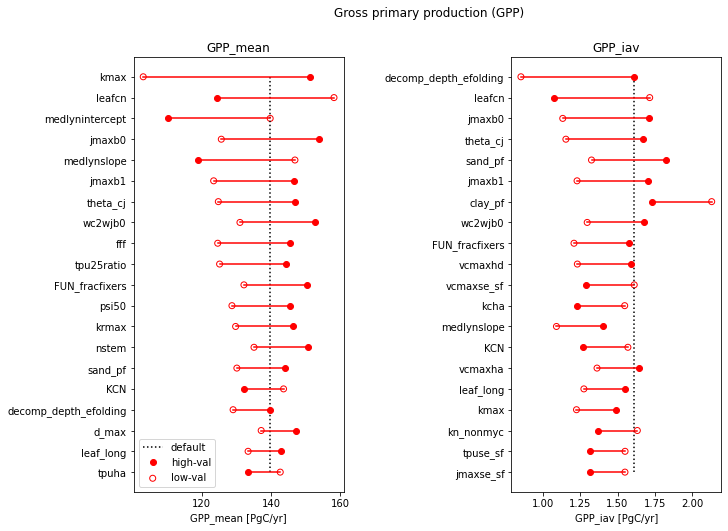

In [66]:
ens_name = 'CTL2010'
nx = 20
save_as = '../figs/'+ens_name+'_'+datavar+'_'+domain+'_top'+str(nx)+'.pdf'
plt.figure(figsize=[12,8])
twoplots(ds,'CTL2010','GPP',la,'global',nx,save_as=save_as)



In [33]:
ds[datavar]

<xarray.DataArray 'GPP' (ens: 371, time: 120, gridcell: 400)>
dask.array<concatenate, shape=(371, 120, 400), dtype=float32, chunksize=(1, 120, 400), chunktype=numpy.ndarray>
Coordinates:
  * gridcell  (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 363 364 365 366 367 368 369 370
  * time      (time) object 2005-01-01 00:00:00 ... 2014-12-01 00:00:00
Attributes:
    long_name:     gross primary production
    units:         gC/m^2/s
    cell_methods:  time: mean

In [103]:
help(calc_mean)

Help on function calc_mean in module __main__:

calc_mean(ds, datavar, la, domain='global')



In [107]:
xm,iav = calc_mean(ds,'GPP',la,domain='biome')

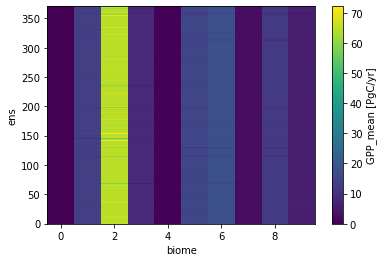

In [110]:
xm.T.plot()

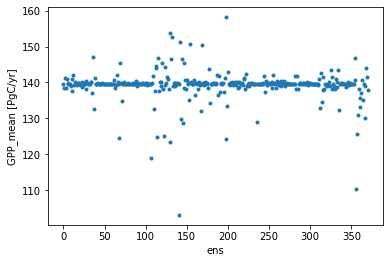

In [106]:
xm.plot.line('.')

In [75]:
g = dsb.biome
dsb[datavar].groupby(g)

DataArrayGroupBy, grouped over 'biome'
10 groups with labels 0.0, 1.0, 2.0, ..., 7.0, 8.0, 9.0.

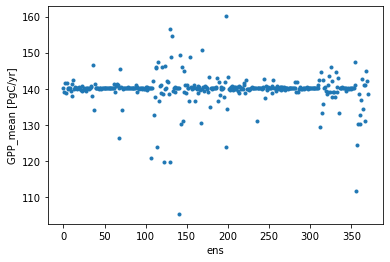

In [68]:
xm.plot.line('.')

In [63]:
out

<xarray.Dataset>
Dimensions:   (ens: 371)
Coordinates:
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 363 364 365 366 367 368 369 370
Data variables:
    GPP_mean  (ens) float64 140.2 139.1 141.5 139.0 ... 131.1 145.0 142.1 138.5
    GPP_iav   (ens) float64 1.331 1.347 1.381 1.294 ... 1.051 1.663 1.823 1.665
    param     (ens) <U32 'default' 'taulnir' 'taulnir' ... 'clay_pf' 'clay_pf'
    minmax    (ens) <U7 'default' 'min' 'max' 'min' ... 'min' 'max' 'min' 'max'

In [ ]:
def calc_mean_biome(ds,datavar,la,domain,ens_name):

    
    
    if not glob.glob(preload):
        #do the calculation
        cf = cfs[datavar]  #conversion factor
        if cf=='intrinsic':
            cf = 1/lab.groupby('biome').sum()/365
        x  = dsb[datavar]

        #calc annual mean or sum (determined by cf)
        xann = cf*(month_wts(10)*(lab*x).groupby('biome').sum()).groupby('time.year').sum().compute()

        #average/iav
        xm  = xann.mean(dim='year') 
        iav = xann.std(dim='year')
        
        #save the reduced data
        out = xr.Dataset()
        out[datavar+'_mean'] = xm
        out[datavar+'_mean'].attrs= {'units':units[datavar]}
        out[datavar+'_iav']  = iav
        out[datavar+'_iav'].attrs= {'units':units[datavar]}
        out['param']  = dsb.param
        out['minmax'] = dsb.minmax
        out.load().to_netcdf(preload)
    

    #load from file
    ds  = xr.open_dataset(preload)
    xm  = ds[datavar+'_mean']
    iav = ds[datavar+'_iav']
    
    return xm,iav